In [19]:
import cdflib
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from pathlib import Path
os.chdir(r'D:/ISRO Hackthon')


Reading: AL1_ASW91_L2_BLK_20240801_UNP_9999_999999_V01.cdf
Error Reading AL1_ASW91_L2_BLK_20240801_UNP_9999_999999_V01.cdf: Variable name 'epoch_for_cdf_mod' not found.
Reading: AL1_ASW91_L2_BLK_20240802_UNP_9999_999999_V01.cdf
Error Reading AL1_ASW91_L2_BLK_20240802_UNP_9999_999999_V01.cdf: Variable name 'epoch_for_cdf_mod' not found.
Reading: AL1_ASW91_L2_BLK_20240803_UNP_9999_999999_V01.cdf
Error Reading AL1_ASW91_L2_BLK_20240803_UNP_9999_999999_V01.cdf: Variable name 'epoch_for_cdf_mod' not found.
Reading: AL1_ASW91_L2_BLK_20240804_UNP_9999_999999_V01.cdf
Error Reading AL1_ASW91_L2_BLK_20240804_UNP_9999_999999_V01.cdf: Variable name 'epoch_for_cdf_mod' not found.
Reading: AL1_ASW91_L2_BLK_20240805_UNP_9999_999999_V01.cdf
Error Reading AL1_ASW91_L2_BLK_20240805_UNP_9999_999999_V01.cdf: Variable name 'epoch_for_cdf_mod' not found.
Reading: AL1_ASW91_L2_BLK_20240806_UNP_9999_999999_V01.cdf
Error Reading AL1_ASW91_L2_BLK_20240806_UNP_9999_999999_V01.cdf: Variable name 'epoch_for_cdf_mo

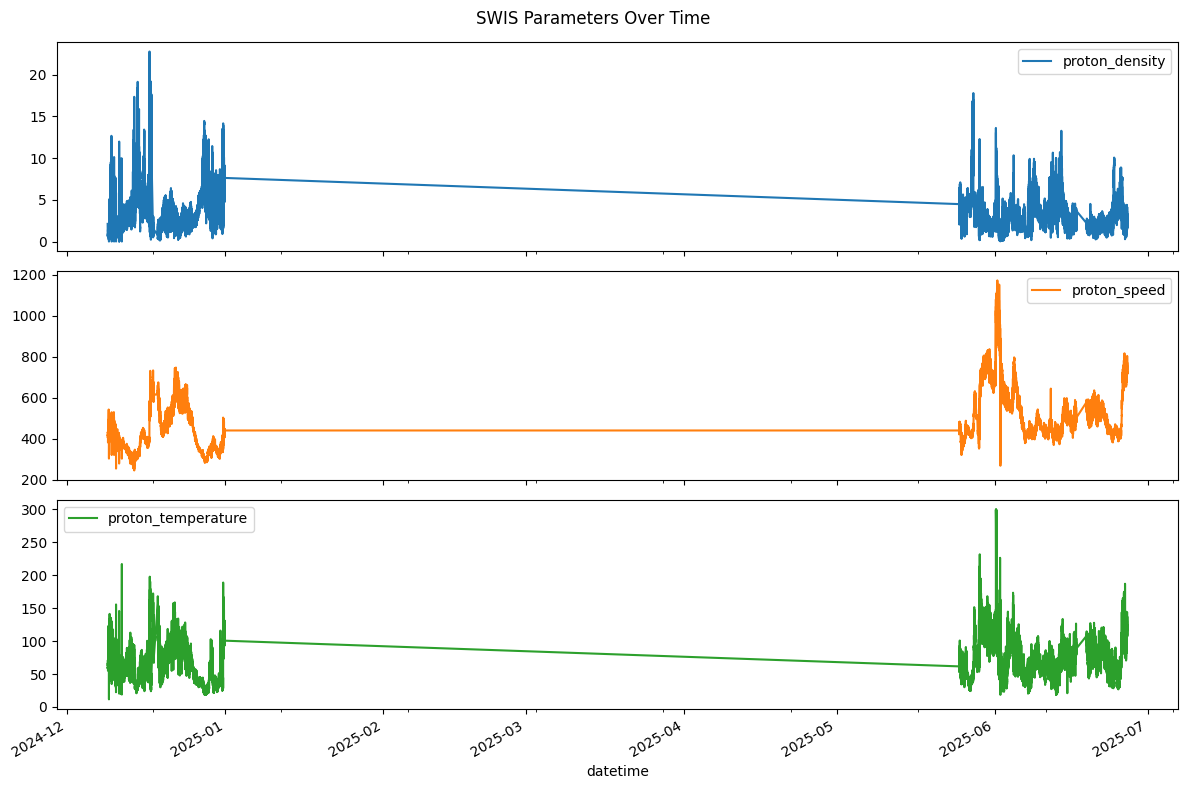

In [33]:
data_folder = Path("HaloCMEs/Data")
all_data = []

for file_path in sorted(data_folder.glob("*.cdf")): #Iterates through all the files with CDF extension
    print(f"Reading: {file_path.name}")
    try:
        cdf_file = cdflib.CDF(str(file_path))
        timestamps = cdf_file.varget('epoch_for_cdf_mod') #epoch is a time tagged coordinate
        datetime_vals = cdflib.cdfepoch.to_datetime(timestamps) #converting the epoch to our normal understanding of time
        datetime_python = pd.to_datetime(datetime_vals)#the ddatetime is in numpy64 fomat which is something i have trouble understanding so i am converting it

        proton_density = cdf_file.varget('proton_density')
        proton_speed = cdf_file.varget('proton_bulk_speed')
        proton_temp = cdf_file.varget('proton_thermal')

        #Creating a Data Frame
        df = pd.DataFrame({
            'datetime' : datetime_python,
            'proton_density' : proton_density,
            'proton_speed' : proton_speed,
            'proton_temperature' : proton_temp
        })

        # Drop rows with invalid values (optional)
        df.replace(-1.0e+31, pd.NA, inplace=True)  # CDF missing values sometimes use extreme values
        df.dropna(inplace=True) #Removes the rows which contain missing values
        #CDF files often use a sentinel value (like -1.0e+31) to indicate missing data.
        #This code replaces those values with pd.NA and drops any rows that have missing values, ensuring that only valid data is plotted.
        all_data.append(df)

    except Exception as e:
        print(f"Error Reading {file_path.name}: {e}")

df = pd.concat(all_data).sort_values('datetime')
df.set_index('datetime', inplace = True)

df.plot(subplots=True, figsize = (12, 8), title = "SWIS Parameters Over Time")
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
data_folder = Path("HaloCMEs/SOHOData")
halo_cme_times = []

for file_path in sorted(data_folder.glob("*.txt")):
    with open(file_path, "r") as file:
        for line in file:
            if "Halo" in line and "360" in line:
                try:
                    date_str = line[0:10].strip()
                    time_str = line[11:19].strip()
                    dt = datetime.strptime(f"{date_str} {time_str}", "%Y/%m/%d %H:%M:%S")
                    halo_cme_times.append(dt)
                except Exception as e:
                    print(f"Error parsing line in {file_path.name}:{line.strip()}")
                    print(f"    {e}")

print("Total Halo CME Events found: ", len(halo_cme_times))
print("First 5 events: ")
for dt in halo_cme_times[:5]:
    print(" ->", dt)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3962186090.py, line 17)

🛰️ CME 100: 2024-12-11 21:12:00 | SWIS records: 2108


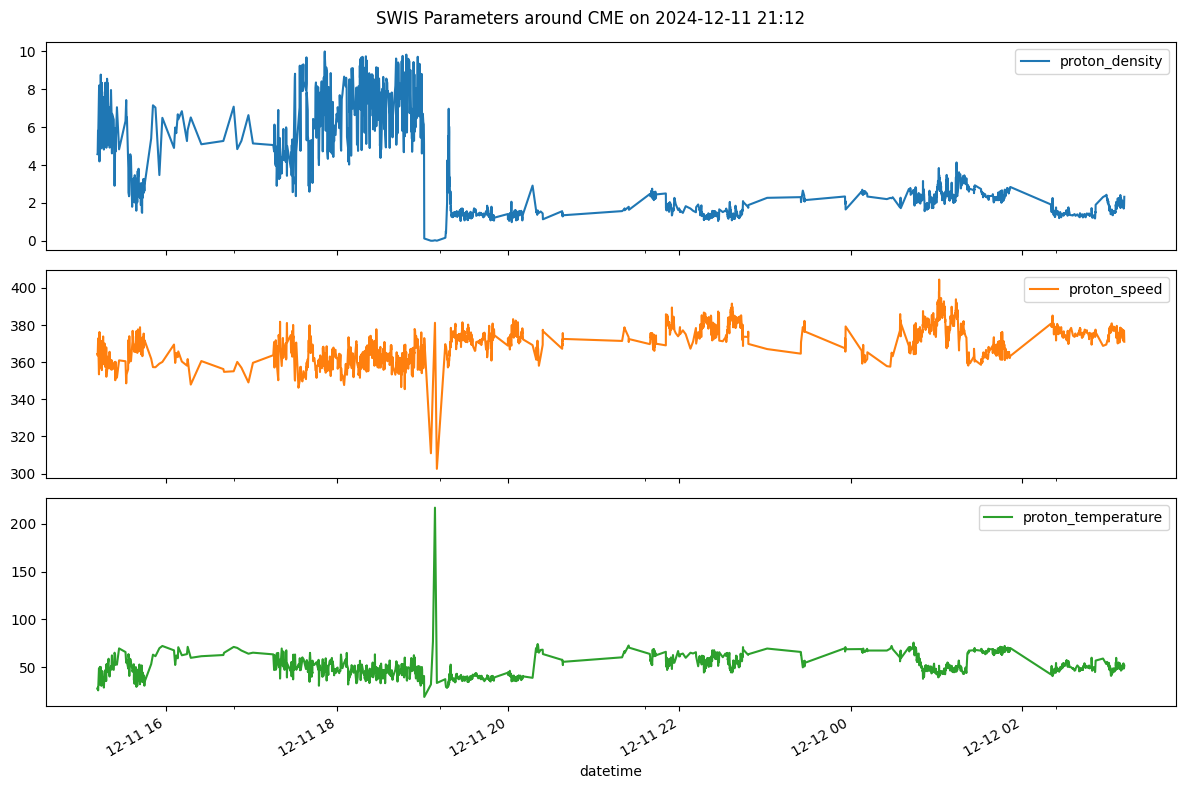

In [22]:
for i, cme_time in enumerate(halo_cme_times[:100]):
    start_time = cme_time - timedelta(hours=6)
    end_time = cme_time + timedelta(hours=6)

    # Relaxed filtering: Find any data within the window
    window_df = df[(df.index >= start_time) & (df.index <= end_time)]

    if len(window_df) == 0:
        continue  # No data for this event

    print(f"🛰️ CME {i+1}: {cme_time} | SWIS records: {len(window_df)}")

    window_df.plot(
        subplots=True,
        figsize=(12, 8),
        title=f'SWIS Parameters around CME on {cme_time.strftime("%Y-%m-%d %H:%M")}',
        sharex=True
    )
    
    plt.tight_layout()
    plt.show()

    if i >= 4:  # Stop after 5 successful plots
        break

In [24]:
matching_cmes = []

for cme_time in halo_cme_times:
    # ±6 hour window
    start = cme_time - timedelta(hours=6)
    end = cme_time + timedelta(hours=6)

    # Check if any SWIS timestamp falls in this range
    if not df.loc[(df.index >= start) & (df.index <= end)].empty:
        matching_cmes.append(cme_time)

# Results
print(f"✅ CME timestamps that overlap with SWIS data: {len(matching_cmes)}")
for dt in matching_cmes[:5]:
    print("  →", dt)

✅ CME timestamps that overlap with SWIS data: 6
  → 2024-12-11 21:12:00
  → 2024-12-15 14:36:00
  → 2024-12-17 16:00:00
  → 2024-12-19 18:16:05
  → 2024-12-23 11:24:00


🛰️ CME 1: 2024-12-11 21:12:00 | SWIS points: 2108


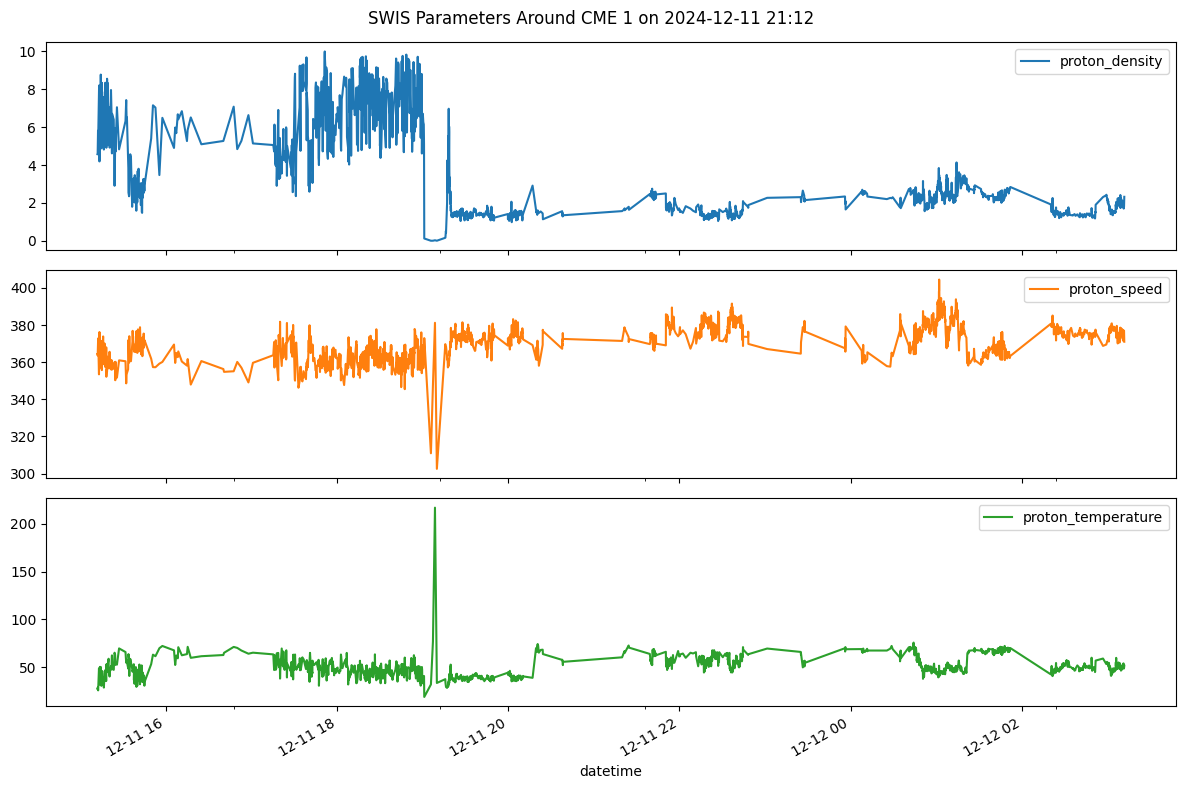

🛰️ CME 2: 2024-12-15 14:36:00 | SWIS points: 3295


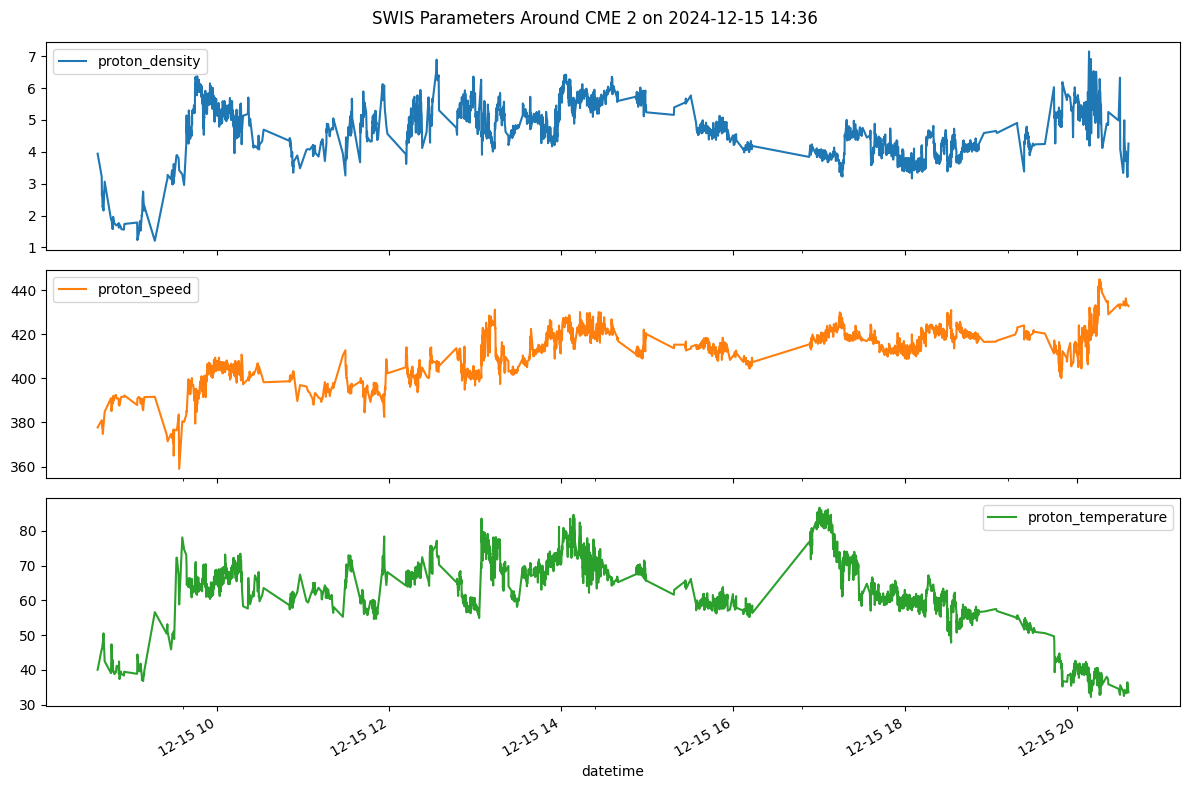

🛰️ CME 3: 2024-12-17 16:00:00 | SWIS points: 1381


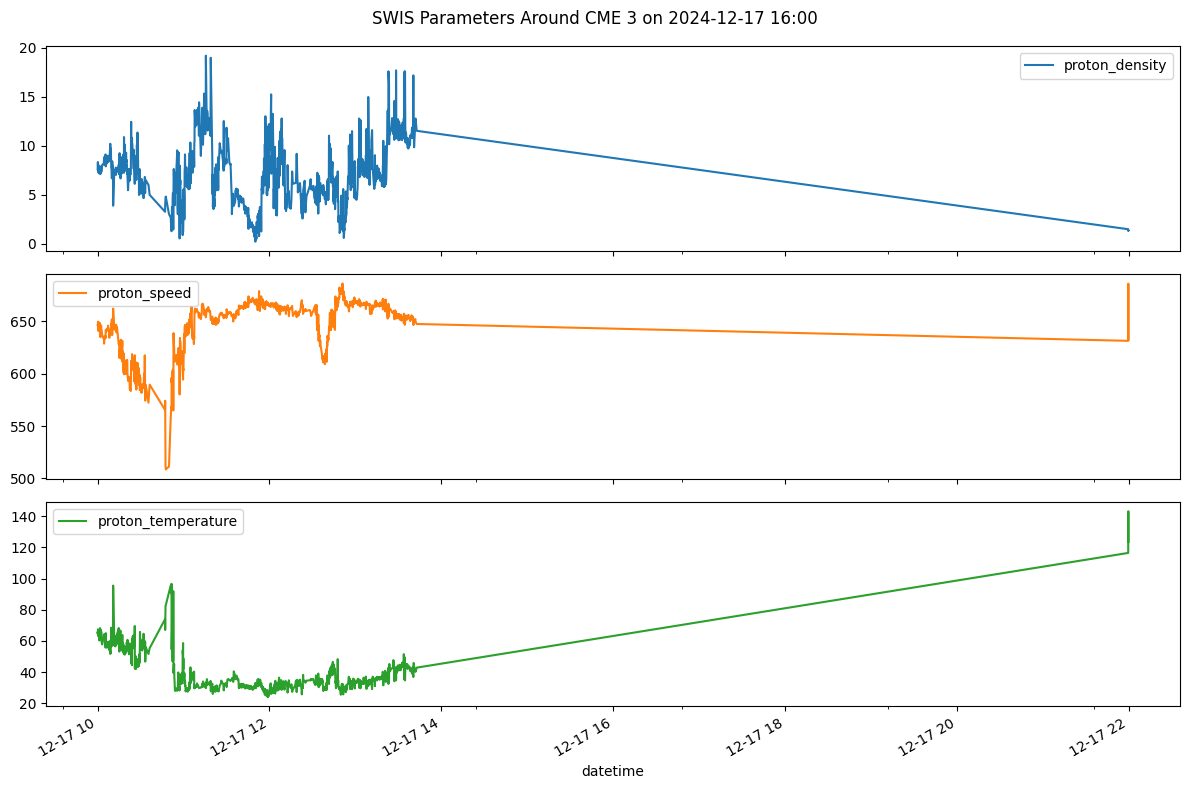

🛰️ CME 4: 2024-12-19 18:16:05 | SWIS points: 4511


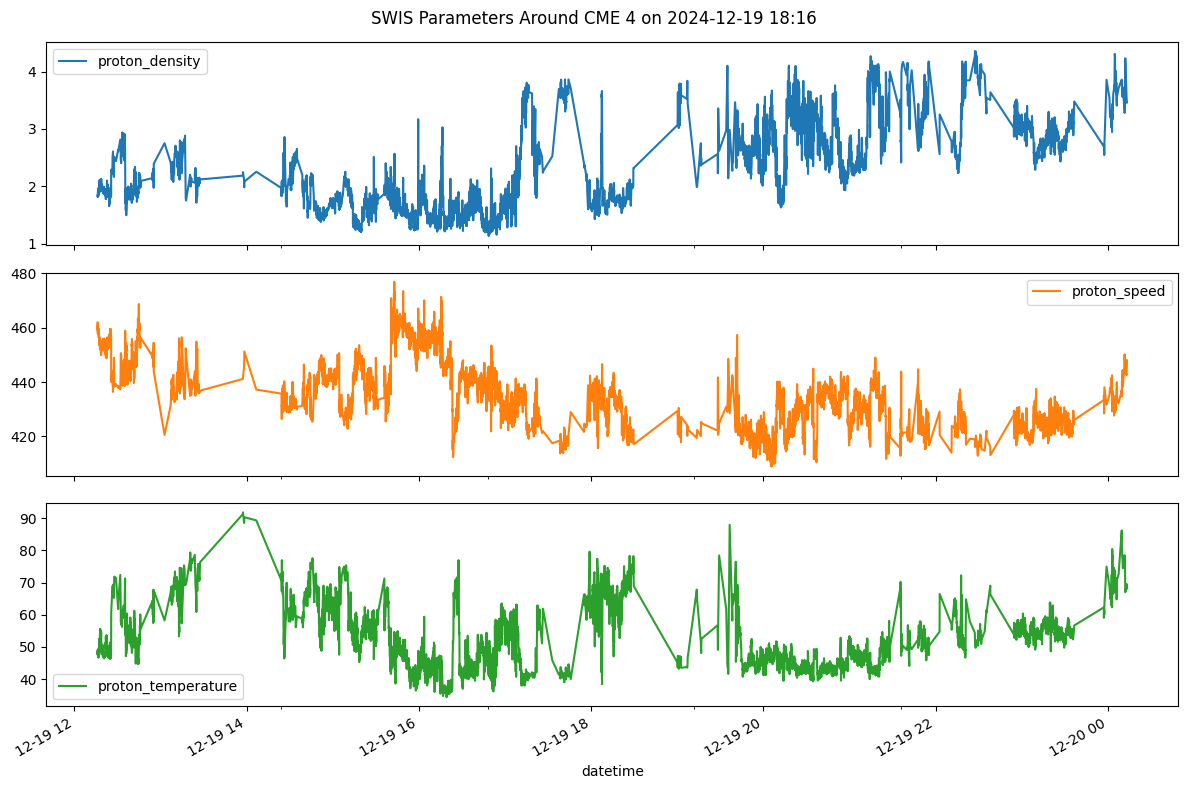

🛰️ CME 5: 2024-12-23 11:24:00 | SWIS points: 1784


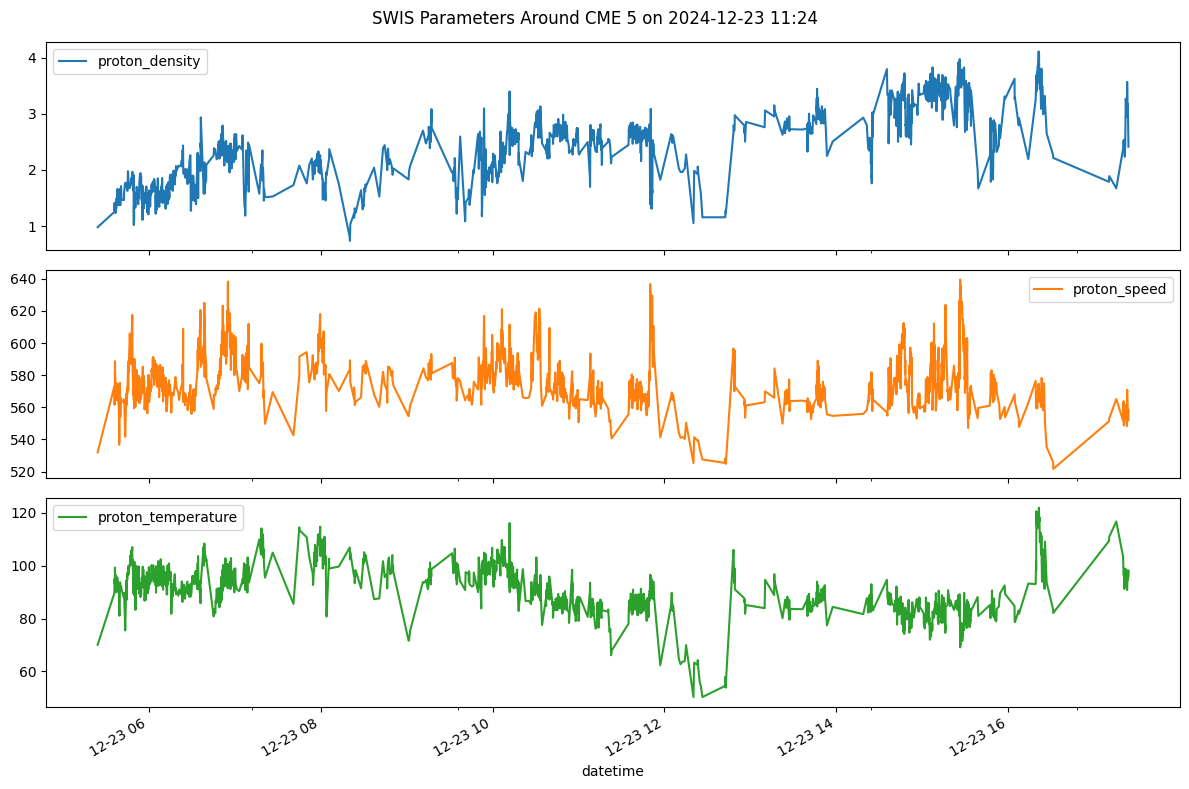

🛰️ CME 6: 2024-12-29 06:12:00 | SWIS points: 2126


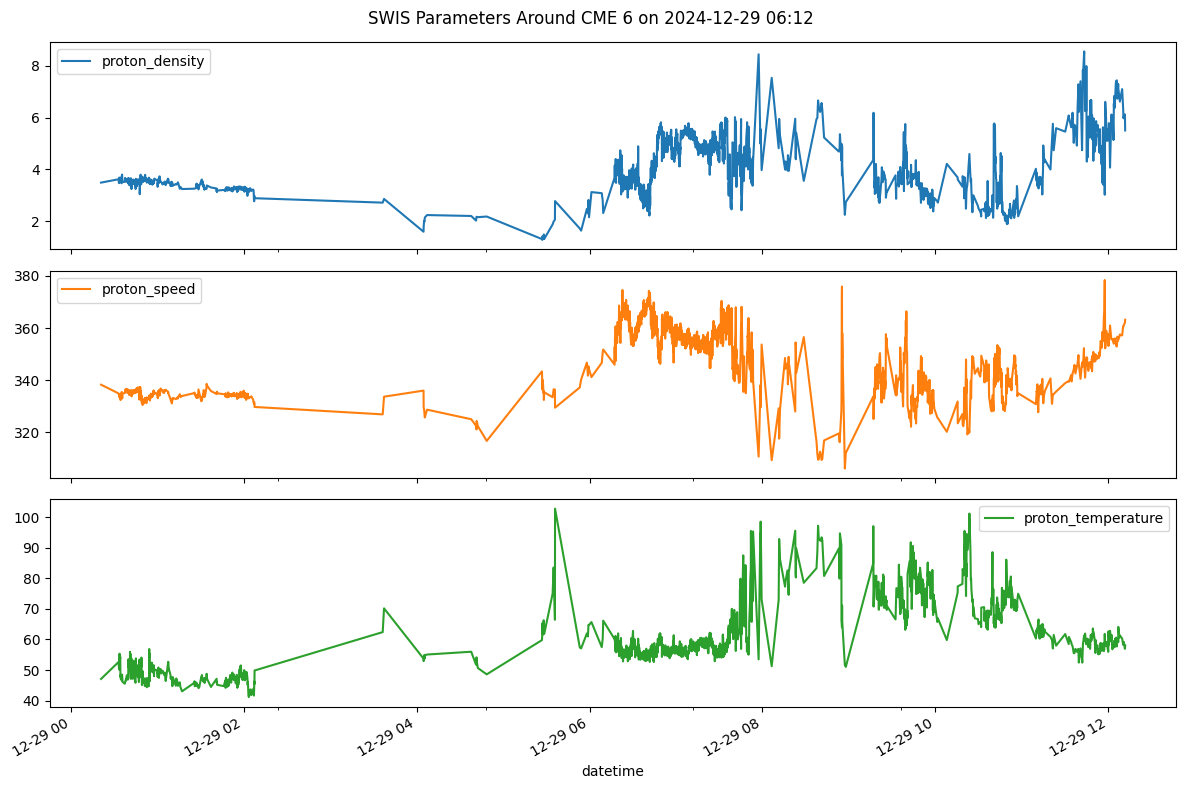

In [25]:
from datetime import timedelta
import matplotlib.pyplot as plt

# Plot all matching CME windows
for i, cme_time in enumerate(matching_cmes):
    start_time = cme_time - timedelta(hours=6)
    end_time = cme_time + timedelta(hours=6)

    window_df = df[(df.index >= start_time) & (df.index <= end_time)]

    if window_df.empty:
        print(f"⚠️ No data found for CME {i+1} at {cme_time}")
        continue

    print(f"🛰️ CME {i+1}: {cme_time} | SWIS points: {len(window_df)}")

    window_df.plot(
        subplots=True,
        figsize=(12, 8),
        title=f'SWIS Parameters Around CME {i+1} on {cme_time.strftime("%Y-%m-%d %H:%M")}',
        sharex=True
    )
    plt.tight_layout()
    plt.show()


In [27]:
def detect_cme_candidates(df, speed_thresh=600, temp_spike=20, dens_spike=2, window=12):
    df = df.copy()

    # Rolling means for smoothing
    df['speed_mean'] = df['proton_speed'].rolling(window=window, center=True).mean()
    df['density_mean'] = df['proton_density'].rolling(window=window, center=True).mean()
    df['temp_mean'] = df['proton_temperature'].rolling(window=window, center=True).mean()

    # Spikes
    df['speed_spike'] = df['proton_speed'] > speed_thresh
    df['temp_spike'] = (df['proton_temperature'] - df['temp_mean']) > temp_spike
    df['dens_spike'] = (df['proton_density'] - df['density_mean']) > dens_spike

    # CME-like if at least 2 out of 3 spike flags are True
    df['cme_like'] = df[['speed_spike', 'temp_spike', 'dens_spike']].sum(axis=1) >= 2

    return df


In [29]:
df_cme = detect_cme_candidates(df)


In [31]:
# Get timestamps where CME-like signature was detected
detected_cmes = df_cme[df_cme['cme_like']].index

print(f"📍 Potential CME candidates found: {len(detected_cmes)}")
print("🕒 Sample detected times:")
for t in detected_cmes[:5]:
    print("  →", t)

📍 Potential CME candidates found: 379
🕒 Sample detected times:
  → 2024-12-10 06:34:54.902000
  → 2024-12-11 06:17:40.851000
  → 2024-12-11 06:34:05.860000
  → 2024-12-13 23:27:48.214000
  → 2024-12-14 04:58:28.385000


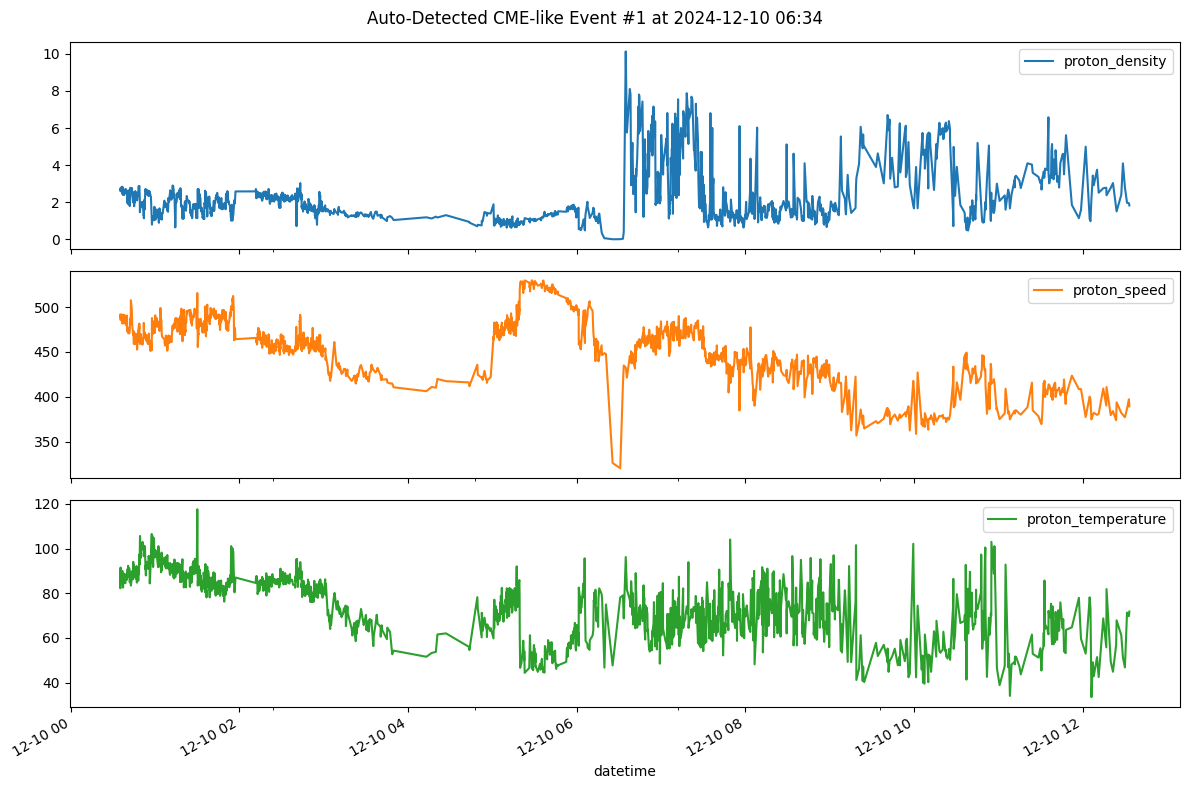

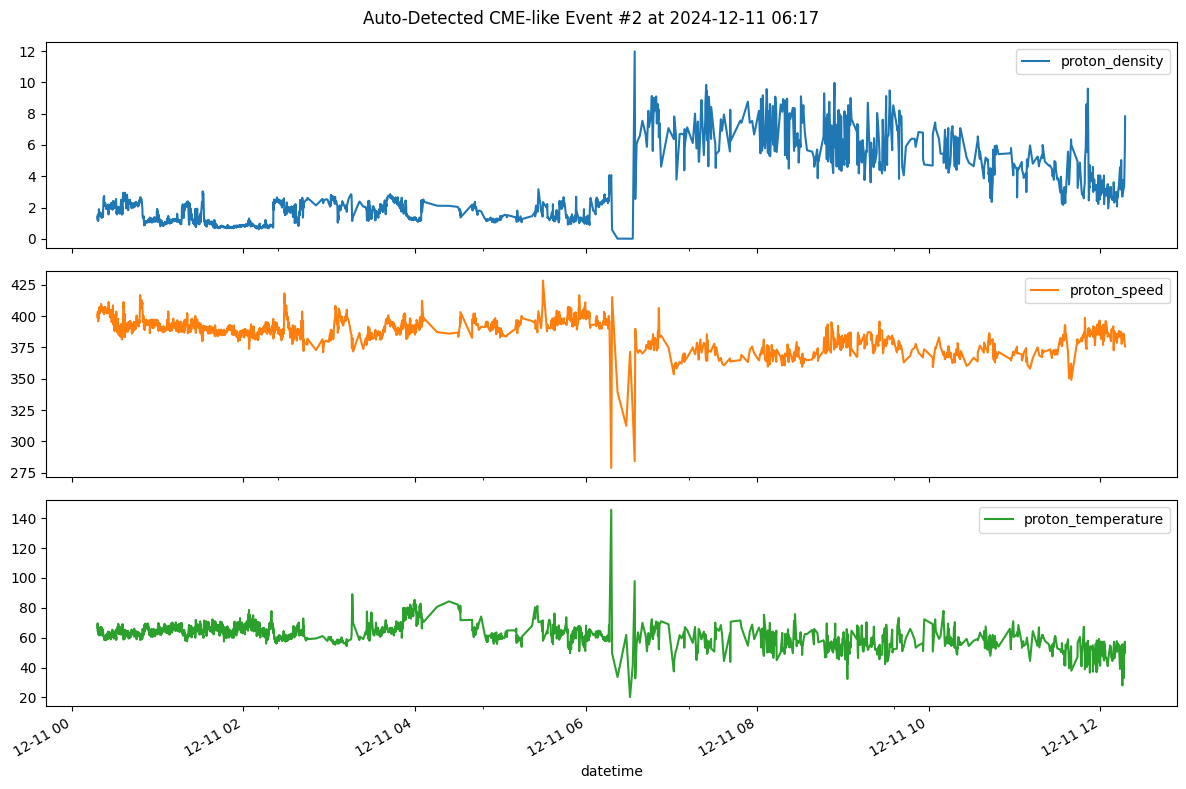

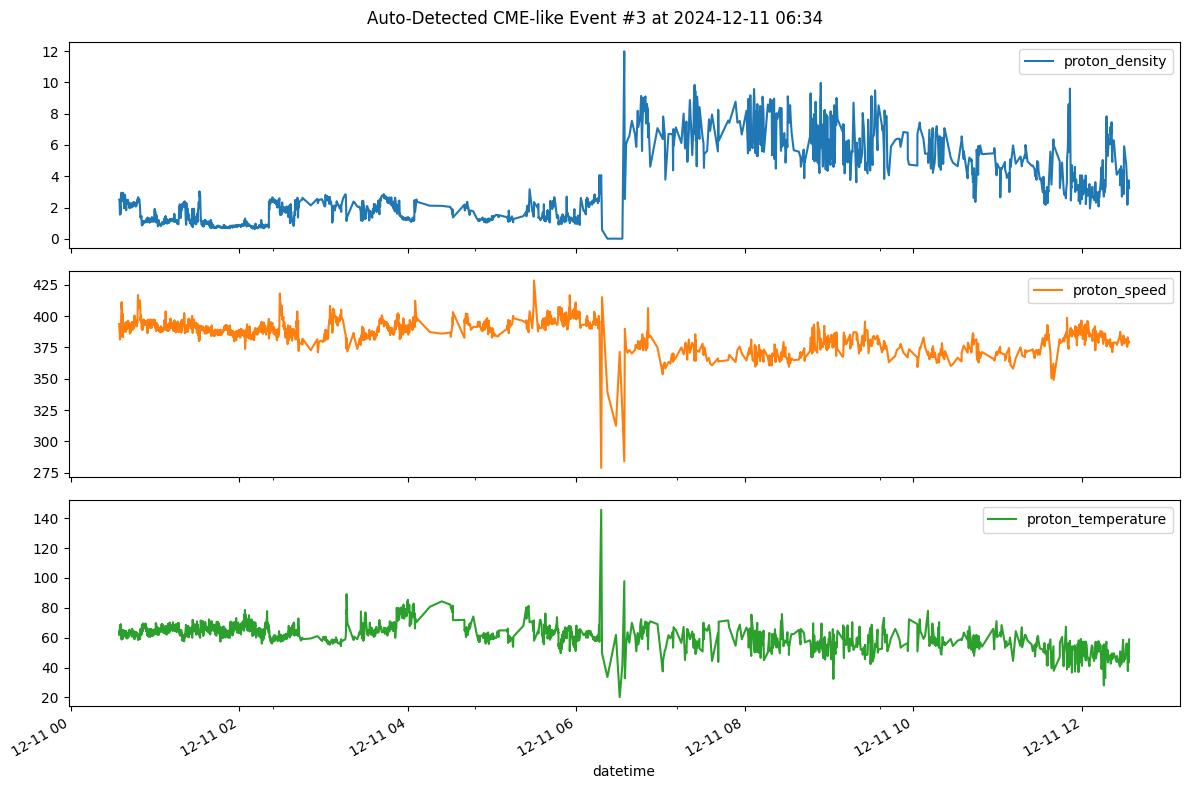

In [32]:
from datetime import timedelta

for i, t in enumerate(detected_cmes[:3]):
    window = df_cme[(df_cme.index >= t - timedelta(hours=6)) & (df_cme.index <= t + timedelta(hours=6))]

    window[['proton_density', 'proton_speed', 'proton_temperature']].plot(
        subplots=True, figsize=(12, 8),
        title=f'Auto-Detected CME-like Event #{i+1} at {t.strftime("%Y-%m-%d %H:%M")}'
    )
    plt.tight_layout()
    plt.show()